# Toxicity Detection in Memes 

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/georgia-tech-db/eva/blob/master/tutorials/10-toxicity-classifier-huggingface.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run on Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/georgia-tech-db/eva/blob/master/tutorials/10-toxicity-classifier-huggingface.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/georgia-tech-db/eva/raw/master/tutorials/10-toxicity-classifier-huggingface.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" /> Download notebook</a>
  </td>
</table>

### Start EVA server

We are reusing the start server notebook for launching the EVA server.

In [1]:
!wget -nc "https://raw.githubusercontent.com/georgia-tech-db/eva/master/tutorials/00-start-eva-server.ipynb"
%run 00-start-eva-server.ipynb
cursor = connect_to_server()

File ‘00-start-eva-server.ipynb’ already there; not retrieving.




[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


nohup eva_server > eva.log 2>&1 &



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


### Load the Memes for analysis

In [2]:
!wget -nc "https://raw.githubusercontent.com/georgia-tech-db/toxicity-classification/main/meme1.jpg"
!wget -nc "https://raw.githubusercontent.com/georgia-tech-db/toxicity-classification/main/meme2.jpg"
response = cursor.execute('DROP TABLE IF EXISTS MemeImages;').fetch_all().as_df()
cursor.execute('LOAD IMAGE "meme*.jpg" INTO MemeImages;').fetch_all().as_df()

File ‘meme1.jpg’ already there; not retrieving.



File ‘meme2.jpg’ already there; not retrieving.



,0
0,Number of loaded IMAGE: 1


### Create OCR Extractor UDF

In [3]:
!wget -nc "https://raw.githubusercontent.com/georgia-tech-db/toxicity-classification/main/ocr_extractor.py"
cursor.execute("DROP UDF OCRExtractor;").fetch_all().as_df()
cursor.execute("""CREATE UDF IF NOT EXISTS OCRExtractor
      INPUT  (frame NDARRAY UINT8(3, ANYDIM, ANYDIM))
      OUTPUT (labels NDARRAY STR(ANYDIM), bboxes NDARRAY FLOAT32(ANYDIM, 4),
              scores NDARRAY FLOAT32(ANYDIM))
      TYPE  Classification
      IMPL  'ocr_extractor.py';
      """).fetch_all().as_df()

File ‘ocr_extractor.py’ already there; not retrieving.



,0
0,UDF OCRExtractor successfully added to the dat...


### Create Custom UDF for Toxicity Classification

In [4]:
!wget -nc "https://raw.githubusercontent.com/georgia-tech-db/toxicity-classification/main/toxicity_classifier.py"
cursor.execute("DROP UDF IF EXISTS ToxicityClassifier;").fetch_all().as_df()
cursor.execute("""
            CREATE UDF ToxicityClassifier
            TYPE HuggingFace
            'task' 'text-classification'
            'model' 'EIStakovskii/xlm_roberta_base_multilingual_toxicity_classifier_plus';
      """).fetch_all().as_df()

File ‘toxicity_classifier.py’ already there; not retrieving.



,0
0,UDF ToxicityClassifier successfully added to t...


### Run Toxicity Classifier on OCR Extracted from Images

In [5]:
response = (
    cursor.execute(
        """SELECT memeimages._row_id, T.label, ToxicityClassifier(label)
                  FROM MemeImages JOIN LATERAL
                  UNNEST(OCRExtractor(data)) AS T(label, bbox, score)
                  ;"""
    )
    .fetch_all()
    .as_df()
)


,memeimages._row_id,T.label,toxicityclassifier.label,toxicityclassifier.score
0,1,CAN'T FucK WITH,LABEL_0,0.932346
1,1,MEIN SWAG E,LABEL_1,0.999521
2,2,YOU CANT SPELL,LABEL_0,0.994370
3,2,CLINTON WITHOUT CNN,LABEL_0,0.999781
4,2,Imgmup-coM,LABEL_0,0.996063


### Visualize Model Output on Images

In [6]:
from pprint import pprint
from matplotlib import pyplot as plt
import cv2
import numpy as np

def annotate_image(detections, input_image_path, image_id):

    color1=(207, 248, 64)
    color2=(255, 49, 49)
    thickness=4

    if image_id == 0:
        image_iloc = 1
    else:
        image_iloc = 3

    df = detections
    df = df.iloc[image_iloc]

    image = cv2.imread(input_image_path)

    if df.size:
        ocr = df['T.label']
        label = df['toxicityclassifier.label']

        if label == "LABEL_0":
            actual_label = "NOT TOXIC"
        else:
            actual_label = "TOXIC"

        plt.imshow(image)
        plt.show()

        cv2.putText(image, actual_label, (25, 200), cv2.FONT_HERSHEY_SIMPLEX, 3, color2, thickness, cv2.LINE_AA) 

        cv2.putText(image, ocr, (25, 250), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color1, thickness, cv2.LINE_AA) 

        plt.imshow(image)
        plt.show()        

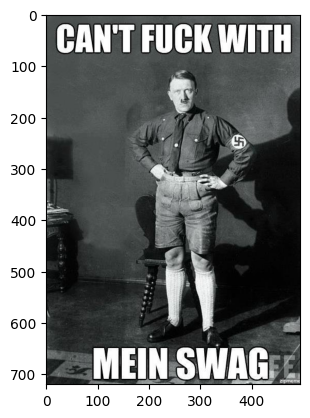

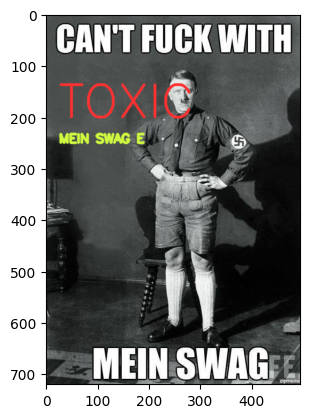

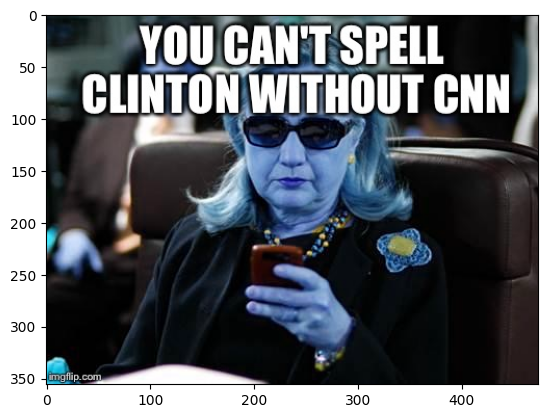

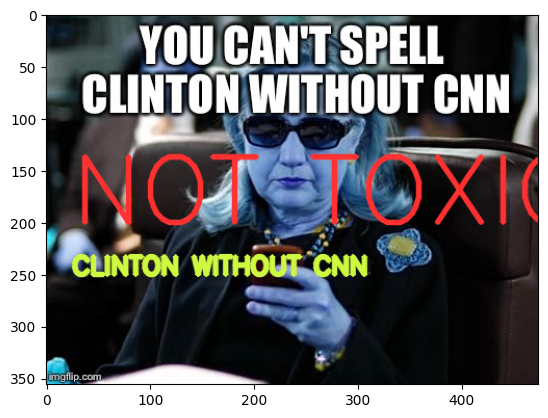

In [7]:
from ipywidgets import Image
annotate_image(response, 'meme1.jpg', image_id=0)
annotate_image(response, 'meme2.jpg', image_id=1)